In [1]:
# 🔐 ACCESS TOKENS (Enter your credentials below)
NYT_API_KEY = 'ZOlnBKpA3FMv3bpiyDpJSkZmroryqlKu'
GUARDIAN_API_KEY = 'e86b7a1d-c0fc-4b00-a820-ce766a4aabcc'
SPOTIFY_CLIENT_ID = '8c428039b02b4ea995601e5e6a1a4fd0'
SPOTIFY_CLIENT_SECRET = 'dc74317bb655405a89c1e9270702dbfd'
GENIUS_API_TOKEN = 'VA1MuzPXk-FHh18kovht9JTJ_ucCZnIm3eWs0jjlvGfGHGRb_6xonF7MvPerG2BC'

## News Collection, Sentiment Analysis, and Preliminary Graph Code

In [11]:
import requests
from datetime import datetime
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt

# --- Download necessary NLTK resources ---
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')

# --- NYT Top Stories API ---
nyt_api = "ZOlnBKpA3FMv3bpiyDpJSkZmroryqlKu"
nyt_url = f'https://api.nytimes.com/svc/topstories/v2/home.json?api-key={nyt_api}'

nyt_articles = []
response = requests.get(nyt_url)
if response.status_code == 200:
    data = response.json()
    for article in data.get('results', []):
        nyt_articles.append(article.get('title', 'No Title') + ": " + article.get('abstract', 'No Abstract'))
else:
    print(f"NYT API Error {response.status_code}: {response.text}")

# --- The Guardian API ---
guardian_api = "e86b7a1d-c0fc-4b00-a820-ce766a4aabcc"
guardian_url = 'https://content.guardianapis.com/search'
today = datetime.now().strftime('%Y-%m-%d')

params = {
    'section': 'us-news',
    'from-date': today,
    'to-date': today,
    'order-by': 'newest',
    'page-size': 8,
    'show-fields': 'trailText',
    'api-key': guardian_api
}

guardian_articles = []
try:
    response = requests.get(guardian_url, params=params)
    response.raise_for_status()
    data = response.json()
    results = data.get('response', {}).get('results', [])
    for article in results:
        title = article.get('webTitle', 'No Title')
        abstract = article.get('fields', {}).get('trailText', 'No Abstract')
        guardian_articles.append(title + ": " + abstract)
except requests.exceptions.RequestException as e:
    print(f"Guardian API Error: {e}")

# --- Sentiment Analysis ---
sentiment_analyzer = SentimentIntensityAnalyzer()
stop_words = set(stopwords.words("english"))

def analyze_sentiment(text_list):
    full_text = ' '.join(text_list)
    tokens = word_tokenize(full_text)
    filtered = [word.lower() for word in tokens if word.isalnum() and word.lower() not in stop_words]
    score = sentiment_analyzer.polarity_scores(' '.join(filtered))
    return score['compound']

nyt_sentiment = analyze_sentiment(nyt_articles)
guardian_sentiment = analyze_sentiment(guardian_articles)

print(f"NYT Headline Sentiment: {nyt_sentiment}")
print(f"Guardian Headline Sentiment: {guardian_sentiment}")


[nltk_data] Downloading package punkt to /Users/noahpurow/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/noahpurow/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/noahpurow/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


NYT Headline Sentiment: -0.5574
Guardian Headline Sentiment: -0.7845


### News Sentiment Comparison: NYT vs Guardian

/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_23943/3245788063.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=outlets, y=scores, palette="pastel")


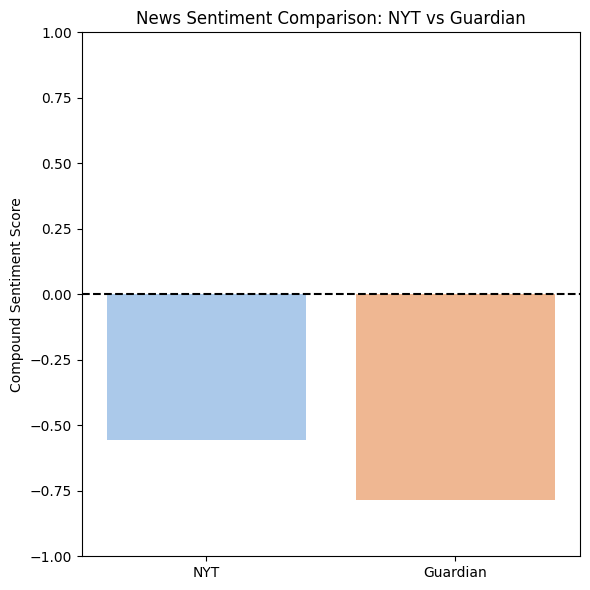

In [10]:
import seaborn as sns
from wordcloud import WordCloud

# --- 1️⃣ Seaborn Bar Plot ---
plt.figure(figsize=(6, 6))
sns.barplot(x=outlets, y=scores, palette="pastel")
plt.title('News Sentiment Comparison: NYT vs Guardian')
plt.ylabel('Compound Sentiment Score')
plt.ylim(-1, 1)
plt.axhline(0, color='black', linestyle='--')
plt.tight_layout()
plt.show()

# Word Cloud of Most Common Words in News

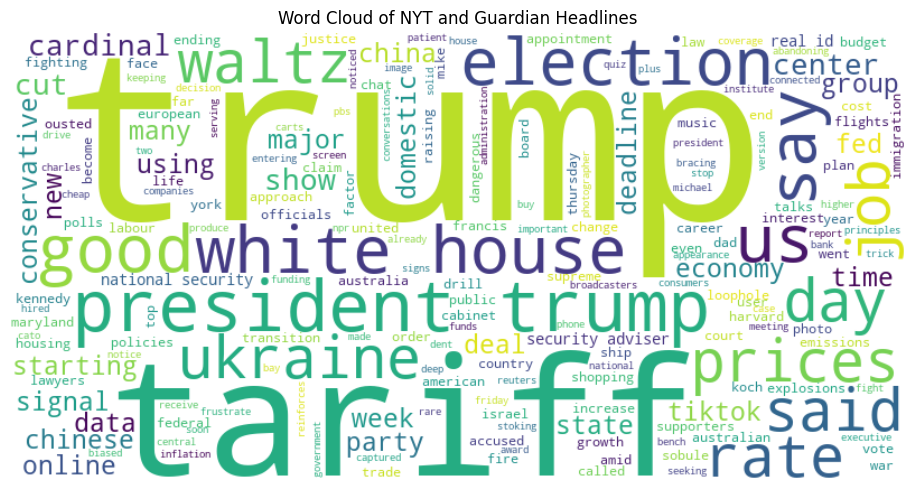

In [12]:
# --- 2️⃣ Word Cloud of News Headlines ---
news_text = ' '.join(nyt_articles + guardian_articles)
stop_words = set(stopwords.words('english'))
filtered_words = ' '.join([
    word for word in nltk.word_tokenize(news_text.lower())
    if word.isalnum() and word not in stop_words
])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(filtered_words)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of NYT and Guardian Headlines')
plt.tight_layout()
plt.show()


### Most Positive and Negative News Headlines

/var/folders/_p/gqrzzrfj0x34qw1lnnq14xsr0000gn/T/ipykernel_23943/3739652088.py:30: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


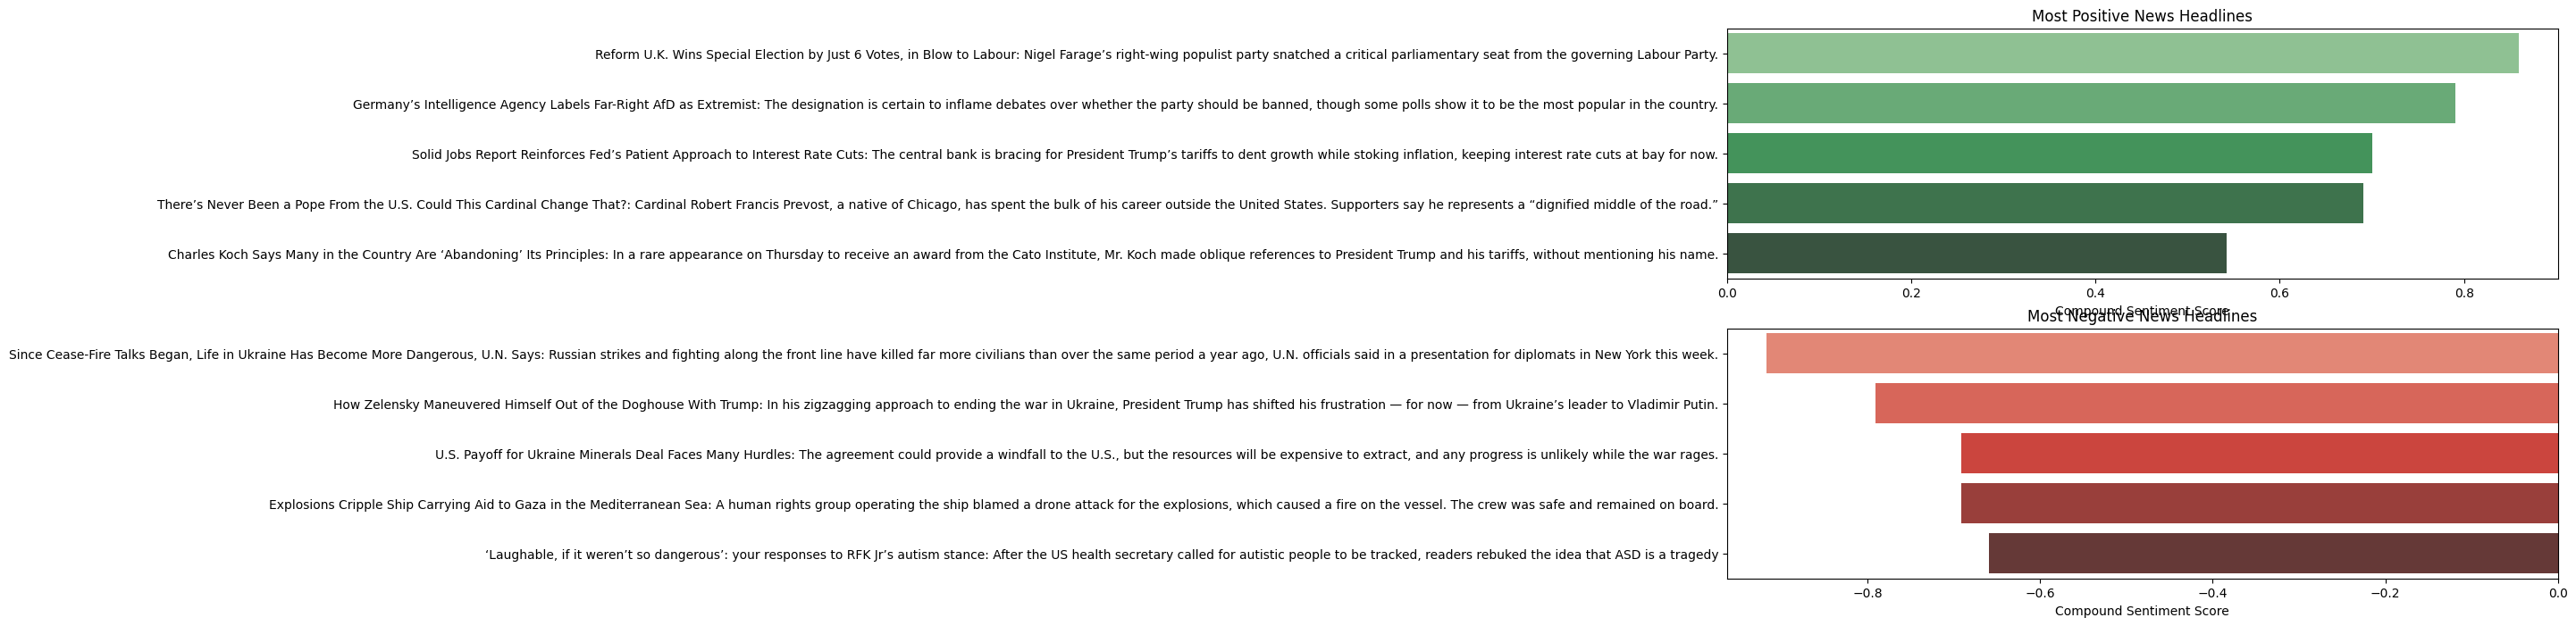

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

plt.figure(figsize=(12, 8))

all_headlines = nyt_articles + guardian_articles
headline_sentiments = [(headline, sia.polarity_scores(headline)['compound']) for headline in all_headlines]

# Sort headlines by sentiment
most_positive = sorted(headline_sentiments, key=lambda x: x[1], reverse=True)[:5]
most_negative = sorted(headline_sentiments, key=lambda x: x[1])[:5]

positive_headlines, positive_scores = zip(*most_positive)
negative_headlines, negative_scores = zip(*most_negative)

# --- Positive Headlines ---
plt.subplot(2, 1, 1)
sns.barplot(x=positive_scores, y=positive_headlines, palette="Greens_d")
plt.title('Most Positive News Headlines')
plt.xlabel('Compound Sentiment Score')

# --- Negative Headlines ---
plt.subplot(2, 1, 2)
sns.barplot(x=negative_scores, y=negative_headlines, palette="Reds_d")
plt.title('Most Negative News Headlines')
plt.xlabel('Compound Sentiment Score')

plt.tight_layout()
plt.show()


### Distribution of Compound Sentiment Scores

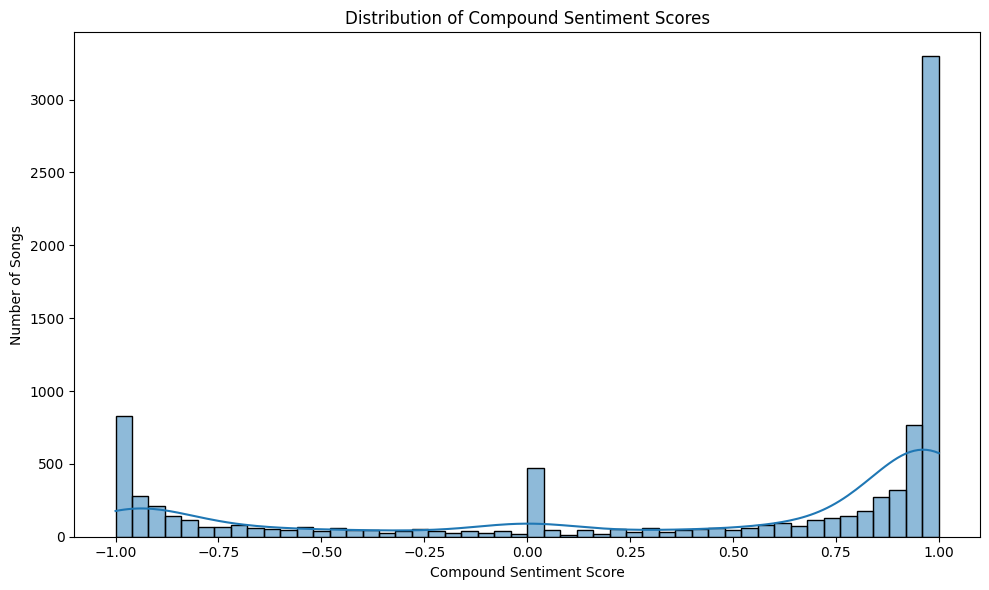

In [19]:
import pandas as pd
# Load dataset
df = pd.read_csv('song_sentiments_emotions.csv')

# Define full emotion list and version without 'neutral'
emotion_cols = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
                'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
                'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
                'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride',
                'realization', 'relief', 'remorse', 'sadness', 'surprise']
emotion_cols_no_neutral = [e for e in emotion_cols if e != 'neutral']

plt.figure(figsize=(10, 6)
)
sns.histplot(df['Compound'], bins=50, kde=True)
plt.title('Distribution of Compound Sentiment Scores')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Number of Songs')
plt.tight_layout()
plt.show()
# --- 2. Count of Songs Where Each Emotion (Excl. Neutral) is the Highest ---
df['top_emotion_no_neutral'] = df[emotion_cols_no_neutral].idxmax(axis=1)
top_emotion_counts_no_neutral = df['top_emotion_no_neutral'].value_counts()

### Number of Songs with Each Emotion (Excl. Neutral) as the Highest

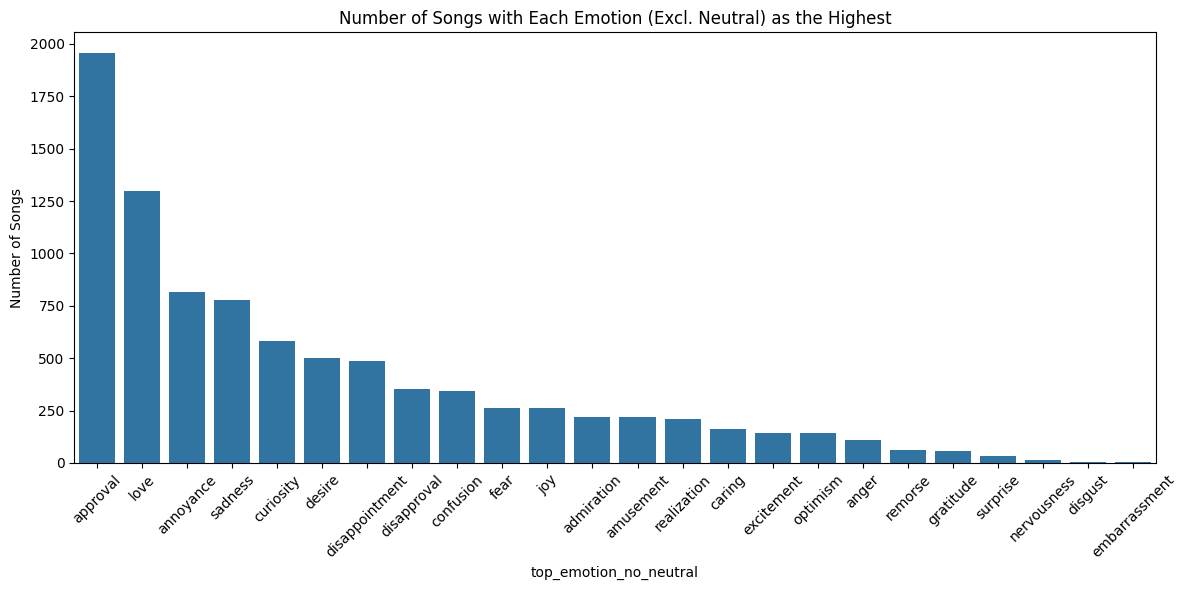

In [20]:
plt.figure(figsize=(12, 6)
)
sns.barplot(x=top_emotion_counts_no_neutral.index, y=top_emotion_counts_no_neutral.values)
plt.title('Number of Songs with Each Emotion (Excl. Neutral) as the Highest')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# --- 3. Emotion Correlation Matrix ---
emotion_corr = df[emotion_cols].corr()

## Correlation Between Emotions

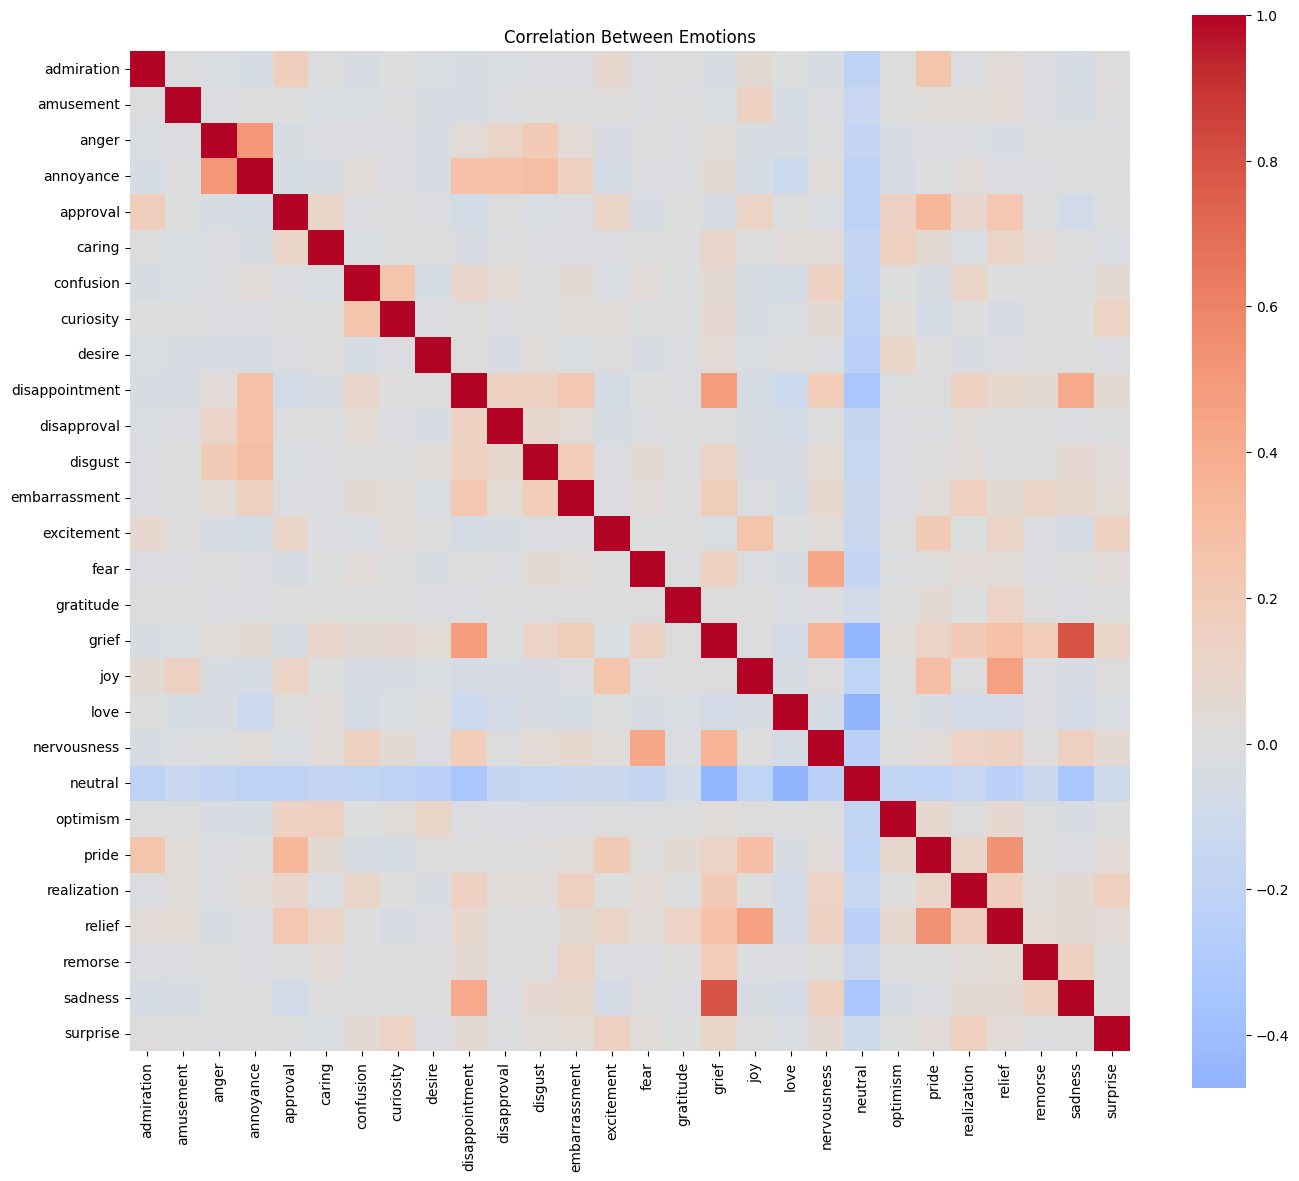

In [28]:
plt.figure(figsize=(14, 12)
)
sns.heatmap(emotion_corr, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Between Emotions')
plt.tight_layout()
plt.show()

## Average Emotion Intensity in Positive vs. Negative Songs (excluding neutral)

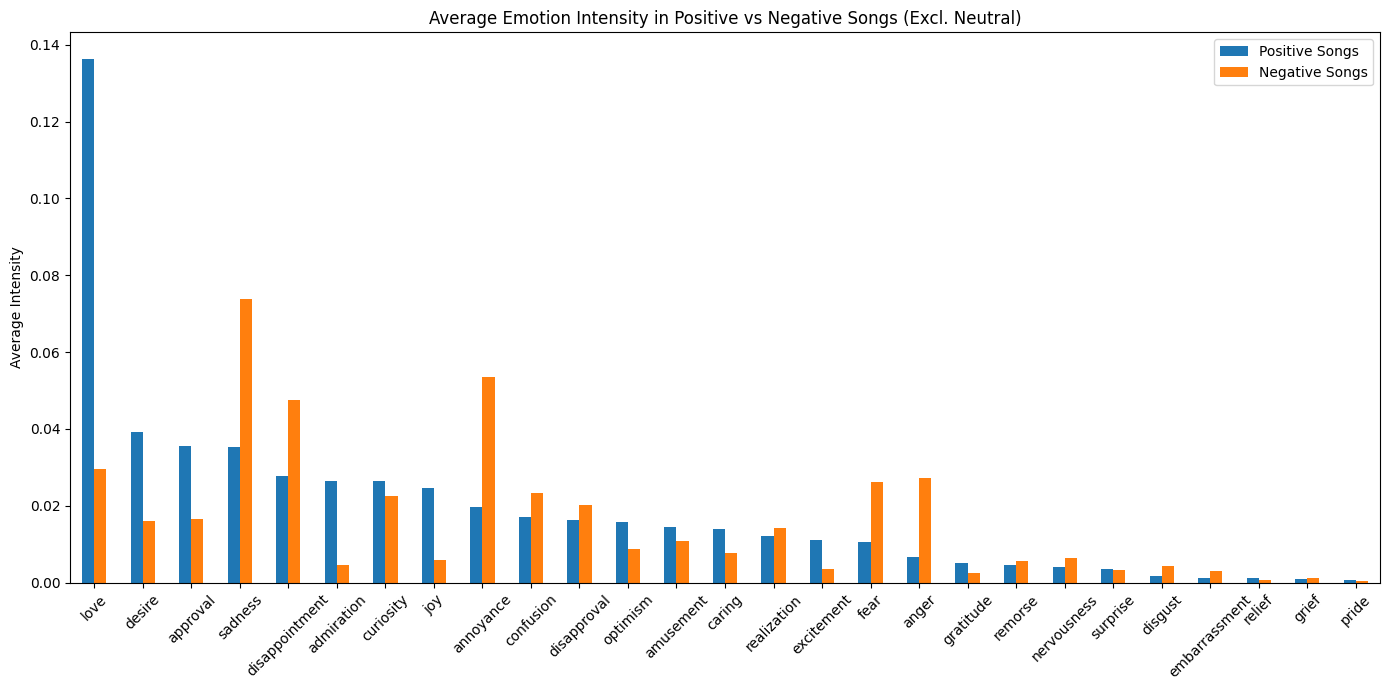

In [27]:
# --- 4. Emotions at Highest Levels in Positive vs Negative Songs (Excl. Neutral) ---
positive_songs = df[df['Compound'] > 0.5]
negative_songs = df[df['Compound'] < -0.5]
positive_means_no_neutral = positive_songs[emotion_cols_no_neutral].mean()
negative_means_no_neutral = negative_songs[emotion_cols_no_neutral].mean()
emotion_sentiment_df_no_neutral = pd.DataFrame({
    'Positive Songs': positive_means_no_neutral,
    'Negative Songs': negative_means_no_neutral
})
emotion_sentiment_df_no_neutral.sort_values('Positive Songs', ascending=False, inplace=True)
emotion_sentiment_df_no_neutral.plot(kind='bar', figsize=(14, 7))
plt.title('Average Emotion Intensity in Positive vs Negative Songs (Excl. Neutral)')
plt.ylabel('Average Intensity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Common Words in Love, Joy, Sad, and Disapproving Songs

🎵 Fetching lyrics for: Route 94 - My Love (Emotion: love)
🎵 Fetching lyrics for: ODESZA - A Moment Apart (Emotion: love)
🎵 Fetching lyrics for: Tina Charles - I Love to Love (Emotion: love)
🎵 Fetching lyrics for: The Soronprfbs - I Love You All (Radio Mix) [feat. Michael Fassbender] (Emotion: love)
🎵 Fetching lyrics for: Adele - Lovesong (Emotion: love)
🎵 Fetching lyrics for: LOCASH - I Love This Life (Emotion: love)
🎵 Fetching lyrics for: Dagny - Love You Like That (Emotion: love)
🎵 Fetching lyrics for: EXID - I Love You (Emotion: love)
🎵 Fetching lyrics for: Easton Corbin - Baby Be My Love Song (Emotion: love)
🎵 Fetching lyrics for: Daft Punk - Make Love (Emotion: love)
🎵 Fetching lyrics for: Siouxsie and the Banshees - Happy House (Emotion: joy)
🎵 Fetching lyrics for: The Wombats - Let's Dance to Joy Division (Emotion: joy)
🎵 Fetching lyrics for: The Jesus and Mary Chain - Happy When It Rains (Emotion: joy)
🎵 Fetching lyrics for: Gene Kelly - Singin' In the Rain (Emotion: joy)
🎵 Fet

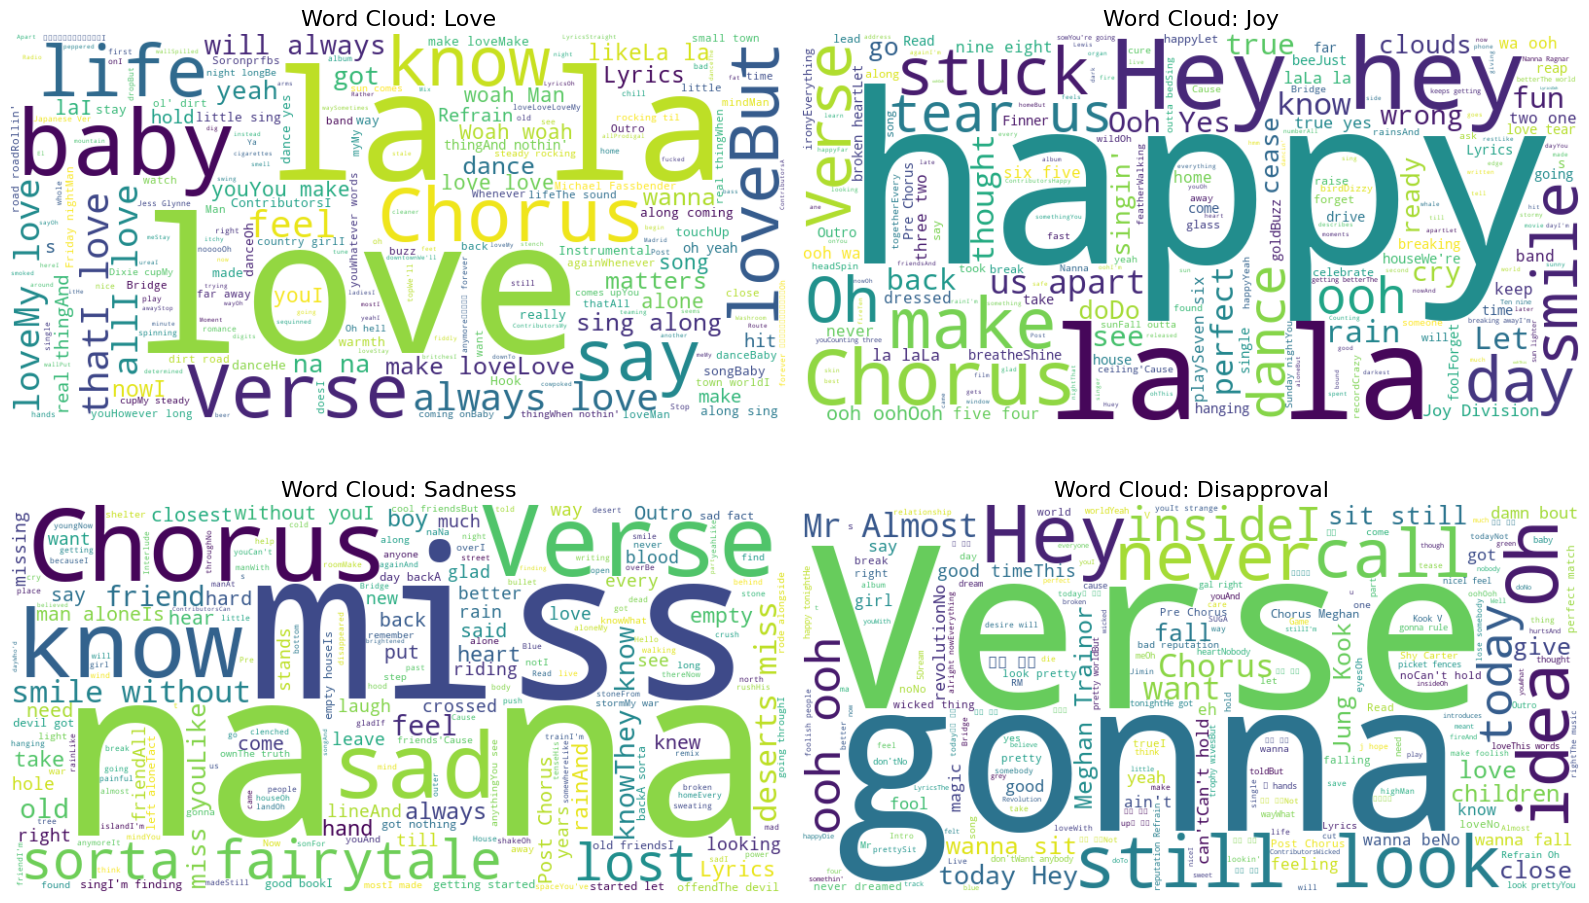

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# --- Emotion Columns ---
emotion_cols_no_neutral = [col for col in df.columns if col in [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride',
    'realization', 'relief', 'remorse', 'sadness', 'surprise'
]]
# ================================
# 1. WORD CLOUDS FOR 4 EMOTIONS
# ================================
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
# --- Setup ---
target_emotions = ['love', 'joy', 'sadness', 'disapproval']
emotion_lyrics = {emotion: [] for emotion in target_emotions}
processed_songs = set()
genius_access_token = "lNVf2vKP-AtDKS1C_mZHoPx4PXAOUvQkWz7qEvcjNLNQ8I88Q17fuoQx5aP17Wws"
genius_headers = {'Authorization': f'Bearer {genius_access_token}'}
# Define emotion columns (excluding 'neutral')
emotion_cols_no_neutral = [col for col in df.columns if col in [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride',
    'realization', 'relief', 'remorse', 'sadness', 'surprise'
]]
# --- Genius scraping functions ---
def get_genius_url(artist, title):
    search_url = 'https://api.genius.com/search'
    query = f"{artist} {title}"
    params = {'q': query}
    response = requests.get(search_url, headers=genius_headers, params=params)
    if response.status_code != 200:
        return None
    hits = response.json().get('response', {}).get('hits', [])
    if hits:
        return hits[0]['result']['url']
    return None
def get_lyrics(genius_url):
    page = requests.get(genius_url)
    soup = BeautifulSoup(page.text, 'html.parser')
    lyrics_containers = soup.find_all('div', attrs={"data-lyrics-container": "true"})
    return "\n".join([div.get_text(strip=True) for div in lyrics_containers])
# --- Fetch Top 10 Songs per Emotion ---
for emotion in target_emotions:
    top10 = df.sort_values(by=emotion, ascending=False).head(10)
    for _, row in top10.iterrows():
        artist = row['Artist']
        title = row['Title']
        song_key = f"{artist} - {title}"
        if song_key in processed_songs:
            continue
        processed_songs.add(song_key)
        print(f"🎵 Fetching lyrics for: {song_key} (Emotion: {emotion})")
        try:
            genius_url = get_genius_url(artist, title)
            if genius_url:
                lyrics = get_lyrics(genius_url)
                emotion_lyrics[emotion].append(lyrics)
            else:
                print("  ❌ Genius URL not found.")
        except Exception as e:
            print(f"  ❌ Error fetching {song_key}: {e}")
        time.sleep(1)
# --- Generate word clouds ---
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.flatten()
for i, emotion in enumerate(target_emotions):
    text = ' '.join(emotion_lyrics[emotion])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Word Cloud: {emotion.capitalize()}', fontsize=16)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

### Top Emotion for Each of the Top 20 Artists

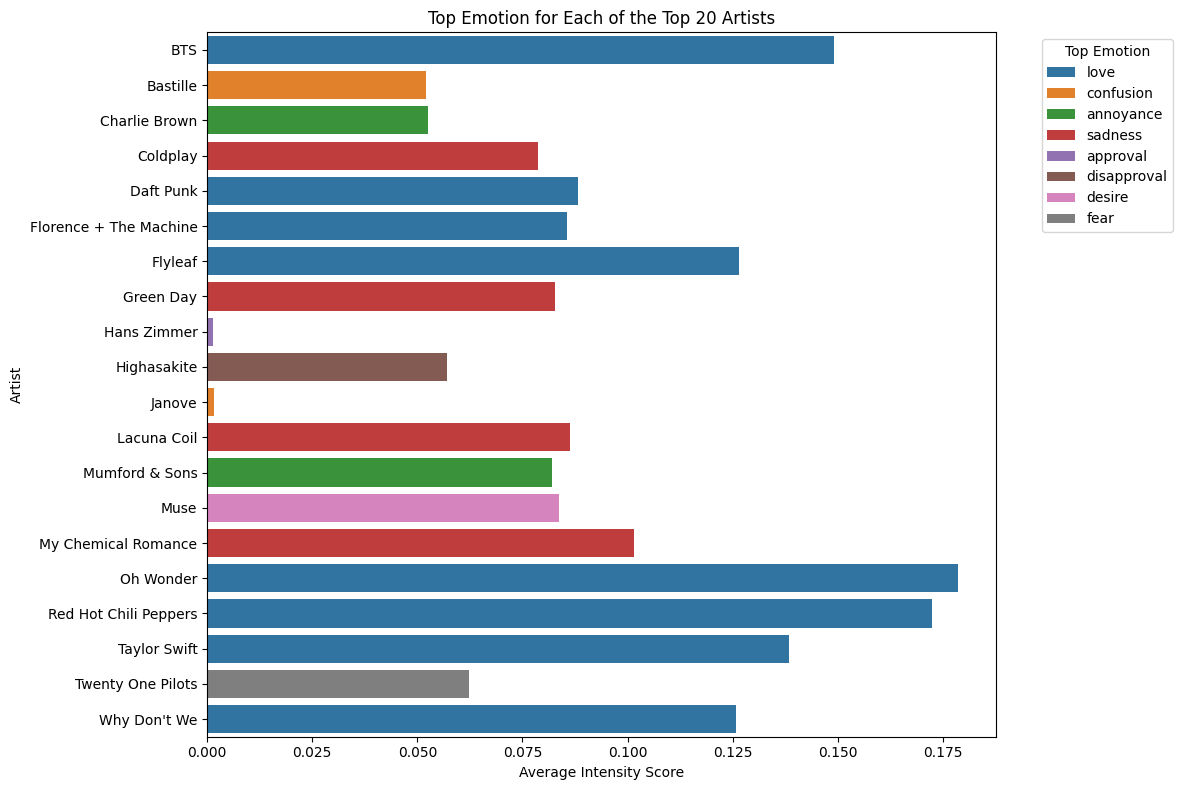

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Define emotion columns (excluding 'neutral')
emotion_cols_no_neutral = [col for col in df.columns if col in [
    'admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring',
    'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval',
    'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief',
    'joy', 'love', 'nervousness', 'optimism', 'pride',
    'realization', 'relief', 'remorse', 'sadness', 'surprise'
]]
# Get top 20 most frequent artists
top_artists = df['Artist'].value_counts().head(20).index
# Filter dataset
df_top = df[df['Artist'].isin(top_artists)]
# Compute average emotion scores per artist
artist_emotions = df_top.groupby('Artist')[emotion_cols_no_neutral].mean()
# Find the highest emotion for each artist
top_emotions = artist_emotions.idxmax(axis=1)
top_scores = artist_emotions.max(axis=1)
# Combine into DataFrame for plotting
artist_top_emotion = pd.DataFrame({
    'Artist': top_emotions.index,
    'Top Emotion': top_emotions.values,
    'Score': top_scores.values
})
# Plot
plt.figure(figsize=(12, 8)
)
sns.barplot(data=artist_top_emotion, x='Score', y='Artist', hue='Top Emotion', dodge=False)
plt.title('Top Emotion for Each of the Top 20 Artists')
plt.xlabel('Average Intensity Score')
plt.ylabel('Artist')
plt.legend(title='Top Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()